In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, MultiHeadAttention, LayerNormalization, Dropout, Layer

# Lab 4 Dataset [cite: 28-71]
data = """
artificial intelligence is transforming modern society.
it is used in healthcare finance education and transportation.
machine learning allows systems to improve automatically with experience.
data plays a critical role in training intelligent systems.
large datasets help models learn complex patterns.
deep learning uses multi layer neural networks.
neural networks are inspired by biological neurons.
each neuron processes input and produces an output.
training a neural network requires optimization techniques.
gradient descent minimizes the loss function.
natural language processing helps computers understand human language.
text generation is a key task in nlp.
language models predict the next word or character.
recurrent neural networks handle sequential data.
lstm and gru models address long term dependency problems.
however rnn based models are slow for long sequences.
transformer models changed the field of nlp.
they rely on self attention mechanisms.
attention allows the model to focus on relevant context.
transformers process data in parallel.
this makes training faster and more efficient.
modern language models are based on transformers.
education is being improved using artificial intelligence.
intelligent tutoring systems personalize learning.
automated grading saves time for teachers.
online education platforms use recommendation systems.
technology enhances the quality of learning experiences.
ethical considerations are important in artificial intelligence.
fairness transparency and accountability must be ensured.
ai systems should be designed responsibly.
data privacy and security are major concerns.
researchers continue to improve ai safety.
text generation models can create stories poems and articles.
they are used in chatbots virtual assistants and content creation.
generated text should be meaningful and coherent.
evaluation of text generation is challenging.
human judgement is often required.
continuous learning is essential in the field of ai.
research and innovation drive technological progress.
students should build strong foundations in mathematics.
programming skills are important for ai engineers.
practical experimentation enhances understanding.
"""

# Tokenization [cite: 23, 77]
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in data.strip().split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

X, y = input_sequences[:,:-1], input_sequences[:,-1]
y_cat = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [3]:
# Component I: RNN/LSTM [cite: 20]
lstm_model = tf.keras.Sequential([
    Embedding(total_words, 100, input_length=max_sequence_len-1),
    LSTM(150),
    Dense(total_words, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Training LSTM...")
history_lstm = lstm_model.fit(X, y_cat, epochs=100, verbose=0) # Capturing history for graphs
print("LSTM Training Complete.")

Training LSTM...
LSTM Training Complete.


In [8]:
# Component II: Transformer [cite: 74]
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Building Transformer [cite: 79]
embed_dim = 64
num_heads = 4
ff_dim = 64

inputs = Input(shape=(max_sequence_len-1,))
x = TokenAndPositionEmbedding(max_sequence_len-1, total_words, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
outputs = Dense(total_words, activation="softmax")(x[:, -1, :])

transformer_model = tf.keras.Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

print("Training Transformer...")
history_transformer = transformer_model.fit(X, y_cat, epochs=100, verbose=0)
print("Transformer Training Complete.")

Training Transformer...
Transformer Training Complete.


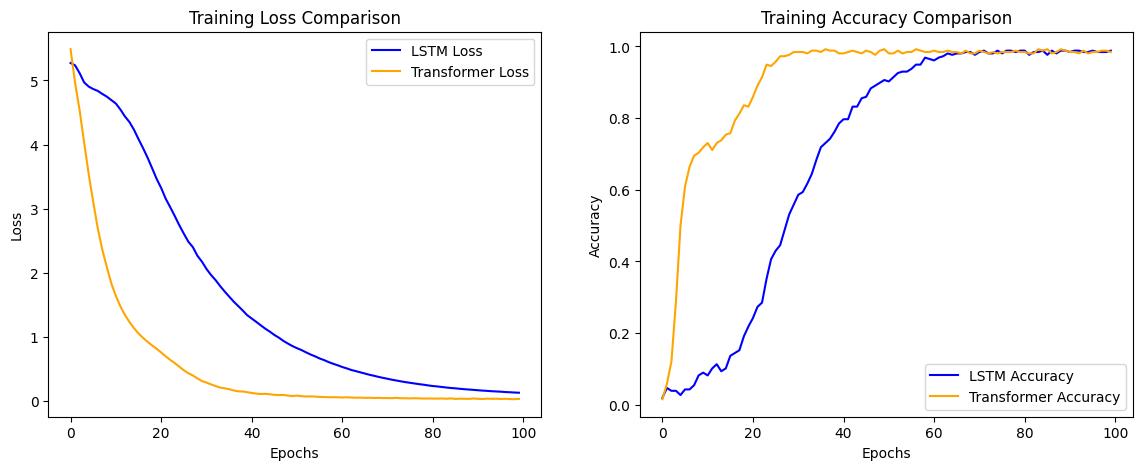


--- Generated Text Samples ---
LSTM: artificial intelligence is transforming modern society society
Transformer: artificial intelligence is transforming modern society transforming


In [9]:
# 1. Visualization of Loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='LSTM Loss', color='blue')
plt.plot(history_transformer.history['loss'], label='Transformer Loss', color='orange')
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 2. Visualization of Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='LSTM Accuracy', color='blue')
plt.plot(history_transformer.history['accuracy'], label='Transformer Accuracy', color='orange')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 3. Generate Text Sample [cite: 27, 81]
def generate_text(model, seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

print("\n--- Generated Text Samples ---")
print("LSTM:", generate_text(lstm_model, "artificial intelligence", 5))
print("Transformer:", generate_text(transformer_model, "artificial intelligence", 5))